# 日経平均株価 15分足

### 一つ上のディレクトリをパスに追加

In [1]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

### ライブラリをここで一括インポート

In [2]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.commons import get_name_15min_chart, get_name_15min_chart_usd

## yfinance による株価データの取得

In [3]:
code = "N225"
symbol = f"^{code}"
ticker1 = yf.Ticker(symbol)
df = ticker1.history(period="1d", interval="15m")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-11-20 09:00:00+09:00,49129.289062,50343.250000,49113.390625,50238.640625,0,0.0,0.0
2025-11-20 09:15:00+09:00,50233.078125,50574.820312,50174.761719,50515.269531,0,0.0,0.0
2025-11-20 09:30:00+09:00,50509.699219,50523.691406,50231.148438,50298.050781,0,0.0,0.0
2025-11-20 09:45:00+09:00,50299.839844,50343.000000,50193.179688,50193.179688,0,0.0,0.0
2025-11-20 10:00:00+09:00,50186.539062,50348.371094,50133.671875,50315.539062,0,0.0,0.0
2025-11-20 10:15:00+09:00,50314.160156,50365.250000,50195.671875,50303.539062,0,0.0,0.0
2025-11-20 10:30:00+09:00,50304.500000,50307.820312,50217.500000,50241.750000,0,0.0,0.0
2025-11-20 10:45:00+09:00,50240.769531,50257.781250,50086.648438,50181.621094,0,0.0,0.0
2025-11-20 11:00:00+09:00,50175.210938,50221.441406,50049.089844,50081.039062,0,0.0,0.0


### ザラ場の時間範囲

In [4]:
dt_start = df.index[0]
dt_end = pd.to_datetime(
    f"{dt_start.year:04d}-{dt_start.month:02d}-{dt_start.day:02d} 15:30:00+09:00"
).tz_convert("Asia/Tokyo")
dt_start, dt_end

(Timestamp('2025-11-20 09:00:00+0900', tz='Asia/Tokyo'),
 Timestamp('2025-11-20 15:30:00+0900', tz='Asia/Tokyo'))

## 前日終値の取得

In [5]:
# 過去一週間のデータを取得
td = datetime.timedelta(days=7)
dt_first = df.index[0]
dt_prev = dt_first - td
df_last = ticker1.history(interval="1d", start=str(dt_prev.date()))
print(df_last["Close"])
n = len(df_last)
lastclose = df_last[n - 2 : n - 1]["Close"].iloc[0]
# lastclose = 44902.27 # 9/16 終値
# 確認のため出力
df_last[n - 2 : n - 1]["Close"]

Date
2025-11-13 00:00:00+09:00    51281.828125
2025-11-14 00:00:00+09:00    50376.531250
2025-11-17 00:00:00+09:00    50323.910156
2025-11-18 00:00:00+09:00    48702.980469
2025-11-19 00:00:00+09:00    48537.699219
2025-11-20 00:00:00+09:00    50025.101562
Name: Close, dtype: float64


Date
2025-11-19 00:00:00+09:00    48537.699219
Name: Close, dtype: float64

### 当日始値 - 前日終値

In [6]:
delta_open = df.head(1)["Open"].iloc[0] - lastclose
print(f"{delta_open:+.2f}")

+591.59


## ローソク足チャート（小さいサイズ）

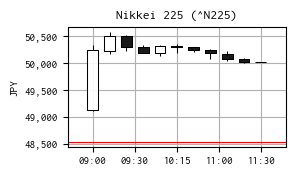

In [7]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))

ax.axhline(y=lastclose, color="red", linewidth=0.75)
mpf.plot(
    df,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax.set_ylabel("JPY")
ax.grid()

if "shortName" in ticker1.info:
    ax.set_title(f"{ticker1.info['shortName']} ({symbol})")
elif "longName" in ticker1.info:
    ax.set_title(f"{ticker1.info['longName']} ({symbol})")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart(code, dt_first))
plt.show()

## ドル円レートで換算

In [8]:
code2 = "USDJPY=X"
symbol2 = code2
ticker2 = yf.Ticker(symbol2)

### 過去２日分のドル円レートの過去データを取得

In [9]:
# 15分足で過去 2 日分のデータを取得
df_exchange = ticker2.history(period="2d", interval="15m")
df_exchange.index = df_exchange.index.tz_convert("Asia/Tokyo")
df_exchange

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-11-19 09:00:00+09:00,155.524002,155.578995,155.417999,155.449005,0,0.0,0.0
2025-11-19 09:15:00+09:00,155.449997,155.472000,155.388000,155.419006,0,0.0,0.0
2025-11-19 09:30:00+09:00,155.414993,155.472000,155.414993,155.421005,0,0.0,0.0
2025-11-19 09:45:00+09:00,155.421997,155.488998,155.367004,155.470001,0,0.0,0.0
2025-11-19 10:00:00+09:00,155.464996,155.513000,155.427002,155.447998,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-11-20 10:45:00+09:00,157.292007,157.436996,157.261993,157.414993,0,0.0,0.0
2025-11-20 11:00:00+09:00,157.414993,157.477005,157.322006,157.403000,0,0.0,0.0
2025-11-20 11:15:00+09:00,157.417999,157.477997,157.365997,157.388000,0,0.0,0.0


### 15分足の Close のドル円レートで一括割る

In [10]:
ser_rate = df_exchange.loc[df.index, "Close"]
ser_rate
df2 = pd.DataFrame()
df2["Open"] = df["Open"] / ser_rate
df2["High"] = df["High"] / ser_rate
df2["Low"] = df["Low"] / ser_rate
df2["Close"] = df["Close"] / ser_rate
df2

,Open,High,Low,Close
Datetime,,,,
2025-11-20 09:00:00+09:00,313.110886,320.847704,313.009562,320.181008
2025-11-20 09:15:00+09:00,319.615923,321.790312,319.244875,321.411410
2025-11-20 09:30:00+09:00,321.373940,321.462967,319.601628,320.027302
2025-11-20 09:45:00+09:00,320.232252,320.507029,319.553203,319.553203
2025-11-20 10:00:00+09:00,319.464157,320.494305,319.127630,320.285311
2025-11-20 10:15:00+09:00,320.194988,320.520119,319.440939,320.127396
2025-11-20 10:30:00+09:00,319.844479,319.865591,319.291319,319.445504
2025-11-20 10:45:00+09:00,319.161272,319.269342,318.182197,318.785524
2025-11-20 11:00:00+09:00,318.769089,319.062797,317.967827,318.170804


### 前日の終値のドル円レートから、前日の終値のドル換算

In [11]:
dt = df_exchange.head(1).index[0]
dt_last_close = pd.to_datetime(f"{str(dt.date())} 15:15:00+09:00")
print(dt_last_close)
last_close_usd = df_exchange.loc[dt_last_close, "Close"]
last_close_usd

2025-11-19 15:15:00+09:00


np.float64(155.34300231933594)

## ローソク足チャート（小さいサイズ）/ ドル換算チャート

前日終値（ドル換算） 312.4550091993966


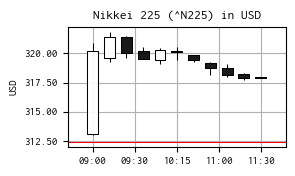

In [12]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))

ax.axhline(y=lastclose / last_close_usd, color="red", linewidth=0.75)
print("前日終値（ドル換算）", lastclose / last_close_usd)
mpf.plot(
    df2,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.2f}"))
ax.set_ylabel("USD")
ax.grid()

if "shortName" in ticker1.info:
    ax.set_title(f"{ticker1.info['shortName']} ({symbol}) in USD")
elif "longName" in ticker1.info:
    ax.set_title(f"{ticker1.info['longName']} ({symbol}) in USD")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart_usd(code, dt_first))
plt.show()